## Step 2

#### Target

1. Reduce model parameters by decreasing # of channel
2. Apply GAP(Global Average Pooling) to increase accuracy
3. Add Batch Normalization to increase accuracy

#### Result

1. Parameters: **8,952**
2. Best Training Accuracy: **99.35**
3. Best Test Accuracy: **99.38**

#### Analysis

1. Model performs very good and very close to the target
2. Model performance is not consistent 
3. There is a bit of fluctuation in the test accuracy

In [1]:
# import necessary libraries

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms

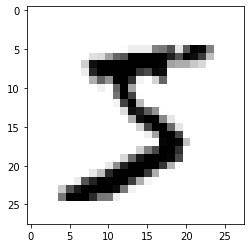

In [2]:
# Download and visualize data

sample_data = datasets.MNIST('./data', train=True, download=True).data

# Setting the values in the data to be within the range [0, 1]
sample_data = sample_data.numpy() / 255

plt.imshow(sample_data[0], cmap='gray_r')

In [3]:
# Calculating Mean and STD for the data

mean = np.mean(sample_data)
std = np.std(sample_data)

print('mean : ', mean)
print('std : ', std)

mean :  0.1306604762738429
std :  0.3081078038564622


### Data Transformation

In [4]:
# Train data transformations
train_transforms = transforms.Compose([
    
    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation
    transforms.Normalize((mean,), (std,))
])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

### Data Loader

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [6]:
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Designing the Model Architecture

In [9]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )  # Input: 28x28x1 | Output: 26x26x8 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(8)
        )  # Input: 26x26x8 | Output: 24x24x8 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 24x24x8 | Output: 22x22x16 | RF: 7x7

        self.pool = nn.MaxPool2d(2, 2)  # Input: 22x22x16 | Output: 11x11x16 | RF: 8x8
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 11x11x16 | Output: 9x9x16 | RF: 12x12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 9x9x16 | Output: 7x7x16 | RF: 16x16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(16)
        )  # Input: 7x7x16 | Output: 5x5x16 | RF: 20x20
        
        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  # Input: 5x5x10 | Output: 1x1x10 | RF: 20x20
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(x, dim=-1)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4            [-1, 8, 24, 24]             584
              ReLU-5            [-1, 8, 24, 24]               0
       BatchNorm2d-6            [-1, 8, 24, 24]              16
            Conv2d-7           [-1, 16, 22, 22]           1,168
              ReLU-8           [-1, 16, 22, 22]               0
       BatchNorm2d-9           [-1, 16, 22, 22]              32
        MaxPool2d-10           [-1, 16, 11, 11]               0
           Conv2d-11             [-1, 16, 9, 9]           2,320
             ReLU-12             [-1, 16, 9, 9]               0
      BatchNorm2d-13             [-1, 16, 9, 9]              32
           Conv2d-14             [

### Train and Test functions

In [11]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100 * correct / processed)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch_ID={batch_idx} Accuracy={train_accuracies[-1]:.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracies[-1]:.2f}%)\n')

In [12]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 15

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9849/10000 (98.49%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9854/10000 (98.54%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0365, Accuracy: 9904/10000 (99.04%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9928/10000 (99.28%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9912/10000 (99.12%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9932/10000 (99.32%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Accuracy: 9908/10000 (99.08%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9933/10000 (99.33%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9921/10000 (99.21%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9924/10000 (99.24%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9926/10000 (99.26%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0249, Accuracy: 9931/10000 (99.31%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9923/10000 (99.23%)

Epoch 15:


Loss=0.09 Batch_ID=937 Accuracy=99.34: 100%|██████████| 938/938 [00:05<00:00, 181.95it/s]



Test set: Average loss: 0.0233, Accuracy: 9938/10000 (99.38%)



### Plot Loss and Accuracy

Text(0.5, 1.0, 'Test Accuracy')

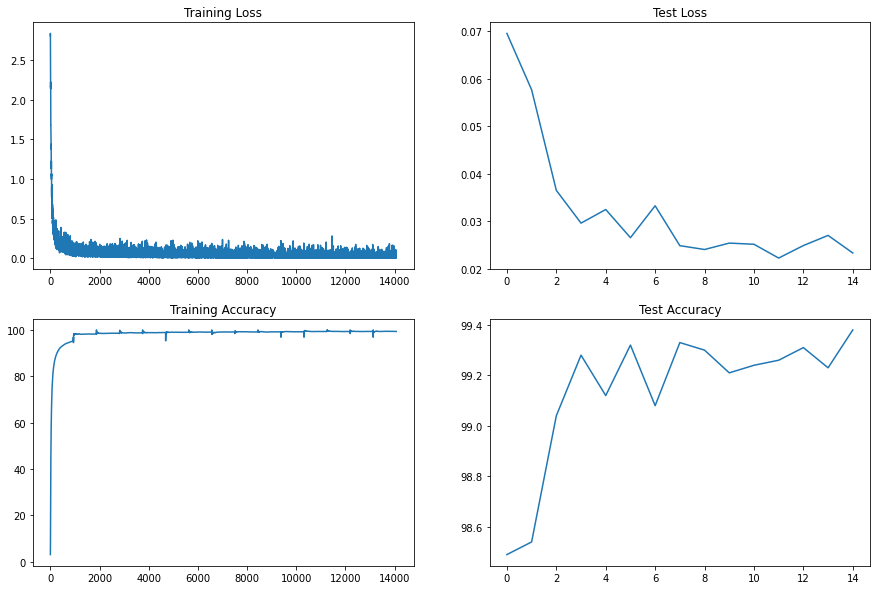

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")